In [88]:
import os
import json
import torch
import numpy as np
import torchvision
from pprint import pprint
from torchvision import ops
from PIL import Image, ImageDraw
from torch.utils.data import Dataset, DataLoader

In [ ]:
class HicoDetDataset(Dataset):
    def __init__(self, dataset_dir, split, transforms=None, nms_threshold=0.7) -> None:
        super().__init__()
        self.dataset_dir = dataset_dir
        self.split = split
        self.nms_threshold = nms_threshold
        self.transforms = transforms
        if self.split == 'train':
            ann_filename = 'trainval_hico.json'
        else:
            ann_filename = 'test_hico.json'
        with open(os.path.join(self.dataset_dir, ann_filename), 'r') as fp:
            self.annotation = json.load(fp=fp)

    def __len__(self):
        return self.annotation

    def __getitem__(self, idx):
        ann = self.annotation[idx]
        img_fn = ann['file_name']
        box_list = [box_class['bbox'] for box_class in ann['annotations']]
        label_list = [box_class['category_id'] for box_class in ann['annotations']]
        image = Image.open(os.path.join(self.dataset_dir, 'images', f'{self.split}2015', img_fn)).convert('RGB')

        boxes = torch.tensor(box_list).float()
        labels = torch.tensor(label_list).int()

        target = dict(boxes=boxes, labels=labels)
        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return img_fn, image, target


In [105]:
hicodet_dataset = HicoDetDataset(dataset_dir='hico_20160224_det', split='train', transforms=None)

In [106]:
hicodet_dataset[0]

('hico_20160224_det/images/train2015/HICO_train2015_00000001.jpg',
 <PIL.Image.Image image mode=RGB size=640x480>,
 {'boxes': tensor([[208.,  33., 427., 300.],
          [ 59.,  98., 572., 405.]]),
  'labels': tensor([0, 3])})

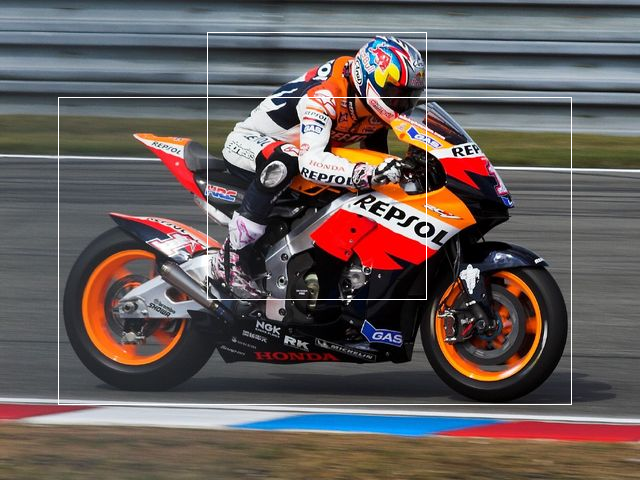

In [91]:
img = Image.open('hico_20160224_det/images/train2015/HICO_train2015_00000001.jpg')
draw = ImageDraw.Draw(img)
draw.rectangle([207, 32, 426, 299])
draw.rectangle([58, 97, 571, 404])
img

In [104]:
hico[0]

{'file_name': 'HICO_train2015_00000001.jpg',
 'img_id': 1,
 'annotations': [{'bbox': [207, 32, 426, 299], 'category_id': 1},
  {'bbox': [58, 97, 571, 404], 'category_id': 4}],
 'hoi_annotation': [{'subject_id': 0,
   'object_id': 1,
   'category_id': 73,
   'hoi_category_id': 153},
  {'subject_id': 0, 'object_id': 1, 'category_id': 77, 'hoi_category_id': 154},
  {'subject_id': 0, 'object_id': 1, 'category_id': 88, 'hoi_category_id': 155},
  {'subject_id': 0,
   'object_id': 1,
   'category_id': 99,
   'hoi_category_id': 156}]}

In [73]:
len(hico)

37633

In [83]:
pprint(hico[0])

{'annotations': [{'bbox': [207, 32, 426, 299], 'category_id': 1},
                 {'bbox': [58, 97, 571, 404], 'category_id': 4}],
 'file_name': 'HICO_train2015_00000001.jpg',
 'hoi_annotation': [{'category_id': 73,
                     'hoi_category_id': 153,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 77,
                     'hoi_category_id': 154,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 88,
                     'hoi_category_id': 155,
                     'object_id': 1,
                     'subject_id': 0},
                    {'category_id': 99,
                     'hoi_category_id': 156,
                     'object_id': 1,
                     'subject_id': 0}],
 'img_id': 1}


In [96]:
coco_class_dict={1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}

hico_verb_dict = {1: 'adjust', 2: 'assemble', 3: 'block', 4: 'blow', 5: 'board', 6: 'break', 7: 'brush_with', 8: 'buy', 9: 'carry', 10: 'catch', 11: 'chase', 12: 'check', 13: 'clean', 14: 'control', 15: 'cook', 16: 'cut', 17: 'cut_with', 18: 'direct', 19: 'drag', 20: 'dribble', 21: 'drink_with', 22: 'drive', 23: 'dry', 24: 'eat', 25: 'eat_at', 26: 'exit', 27: 'feed', 28: 'fill', 29: 'flip', 30: 'flush', 31: 'fly', 32: 'greet', 33: 'grind', 34: 'groom', 35: 'herd', 36: 'hit', 37: 'hold', 38: 'hop_on', 39: 'hose', 40: 'hug', 41: 'hunt', 42: 'inspect', 43: 'install', 44: 'jump', 45: 'kick', 46: 'kiss', 47: 'lasso', 48: 'launch', 49: 'lick', 50: 'lie_on', 51: 'lift', 52: 'light', 53: 'load', 54: 'lose', 55: 'make', 56: 'milk', 57: 'move', 58: 'no_interaction', 59: 'open', 60: 'operate', 61: 'pack', 62: 'paint', 63: 'park', 64: 'pay', 65: 'peel', 66: 'pet', 67: 'pick', 68: 'pick_up', 69: 'point', 70: 'pour', 71: 'pull', 72: 'push', 73: 'race', 74: 'read', 75: 'release', 76: 'repair', 77: 'ride', 78: 'row', 79: 'run', 80: 'sail', 81: 'scratch', 82: 'serve', 83: 'set', 84: 'shear', 85: 'sign', 86: 'sip', 87: 'sit_at', 88: 'sit_on', 89: 'slide', 90: 'smell', 91: 'spin', 92: 'squeeze', 93: 'stab', 94: 'stand_on', 95: 'stand_under', 96: 'stick', 97: 'stir', 98: 'stop_at', 99: 'straddle', 100: 'swing', 101: 'tag', 102: 'talk_on', 103: 'teach', 104: 'text_on', 105: 'throw', 106: 'tie', 107: 'toast', 108: 'train', 109: 'turn', 110: 'type_on', 111: 'walk', 112: 'wash', 113: 'watch', 114: 'wave', 115: 'wear', 116: 'wield', 117: 'zip'}

In [100]:
with open('coco_classes.json', 'a') as fp:
    json.dump(coco_class_dict, fp=fp)

with open('hico_verbs.json', 'a') as fp:
    json.dump(hico_verb_dict, fp=fp)